# DSCI 100: Individual Project Planning Stage  
**Name:** Ishir Ghatpande  
**Dataset:** Minecraft Research Server (players.csv, sessions.csv)


 # 1. Data Description

**Importing the datasets:** 

In [ ]:
library(tidyverse)

players_url <- "players.csv"
sessions_url <- "sessions.csv"

players <- read_csv(players_url, show_col_types = FALSE)
sessions <- read_csv(sessions_url, show_col_types = FALSE)

head(players)
head(sessions)

###  players.csv

- **Number of observations:** 196  
- **Number of variables:** 7  
- **Purpose:** Contains one row per unique player with demographic and experience related data.  
- **Variable summary:**

| Variable | Type | Description | Example Value |
|-----------|------|--------------|----------------|
| `experience` | Categorical  | The player’s self-reported skill level in Minecraft (Pro, Veteran, Regular, Amateur). | `"Pro"` |
| `subscribe` | Logical | Whether the player subscribed to the newsletter. This will serve as the response variable in the analysis. | `TRUE` |
| `hashedEmail` | Character | Anonymized player ID used to link with the sessions dataset. | `"f6daba428a5e..."` |
| `played_hours` | Numeric | Total number of hours played by the user. | `30.3` |
| `name` | Character | The first name associated with the player’s account | `"Morgan"` |
| `gender` | Categorical  | Player’s gender. | `"Male"` |
| `Age` | Numeric  | Player’s reported age. | `21` |

#### Summary statistics 
- Mean **played_hours**: 5.85 hours, min = 0, max = 223.
- Mean **Age**: 21.14 years 
- The most common experience level is Amateur, and roughly 74% of players subscribed to the newsletter.  
- There are a few missing values in `Age` (2 missing).  

#### Potential issues
- `played_hours` shows a lot of variability .  
- The `gender` field contains 7 unique values, suggesting inconsistent data entry liked mixed capitalisation or short hands.  
- The dataset is self-reported and may include bias or inaccurate information like incorrect ages.  

---

### sessions.csv

- **Number of observations:** 1 535  
- **Number of variables:** 5  
- **Purpose:** Contains one row per recorded game session with start and end times.  

| Variable | Type | Description | Example Value |
|-----------|------|--------------|----------------|
| `hashedEmail` | Character | Player identifier matching `players.csv`. | `"fd6563a4e0f6..."` |
| `start_time` | Character  | Start time of the game session (local date/time format). | `"30/06/2024 18:12"` |
| `end_time` | Character  | End time of the game session. | `"30/06/2024 18:24"` |
| `original_start_time` | Numeric  | start time  | `1.7197e+12` |
| `original_end_time` | Numeric  | end time. | `1.7197e+12` |

#### Summary statistics
- Mean original_start_time ≈ 1.72 × 10¹² 
- Mean original_end_time ≈ 1.72 × 10¹²
- 125 unique players appear in the sessions log.  
- The most active player recorded 310 sessions.

#### Potential issues
- Some players appear many more times than others, which can cause imbalance in gameplay representation.  
- The timestamps are in epoch format, which must be converted into a human-readable date/time for analysis.

### Data collection 
- The data were automatically collected by a research Minecraft server that logs each player’s in-game behaviour.  
- All identifiers are hashed for privacy.  
- Potential unseen issues include logging errors, server downtime, or players using multiple accounts, which could affect reliability. 

# 2. Questions

### Broad Question
What player characteristics and behaviours are most predictive of subscribing to the game-related newsletter, and how do these features differ between various player types??

### Specific Predictive Question
Can we accurately predict whether a player subscribes to the newsletter using their demographic variables (e.g., age, gender, experience level) and behavioural indicators such as total played hours and number of early sessions in the Minecraft research server dataset?

### How the Data Will Help
- The `players.csv` dataset provides demographic and engagement-related variables, including `experience`, `played_hours`, `gender`, and the response variable `subscribe`, which indicates whether each player joined the newsletter.  
- The `sessions.csv` dataset contains detailed logs of individual play sessions (`start_time`, `end_time`, `hashedEmail`), allowing behavioural metrics such as session count, mean session duration, or time-of-day activity to be aggregated for each player.  
- By joining both datasets on `hashedEmail`, we can construct a player-level dataset that combines who the player is(demographics) with how they behave (game activity).  

 # 3. Exploratory Data Analysis and Visualization


**Mean for quantitative variables in players.csv**

In [ ]:
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(cols = everything(),
               names_to = "Variable",
               values_to = "Mean_Value") |>
  mutate(Mean_Value = round(Mean_Value, 2))

players_means


**Average played hours by experince level**

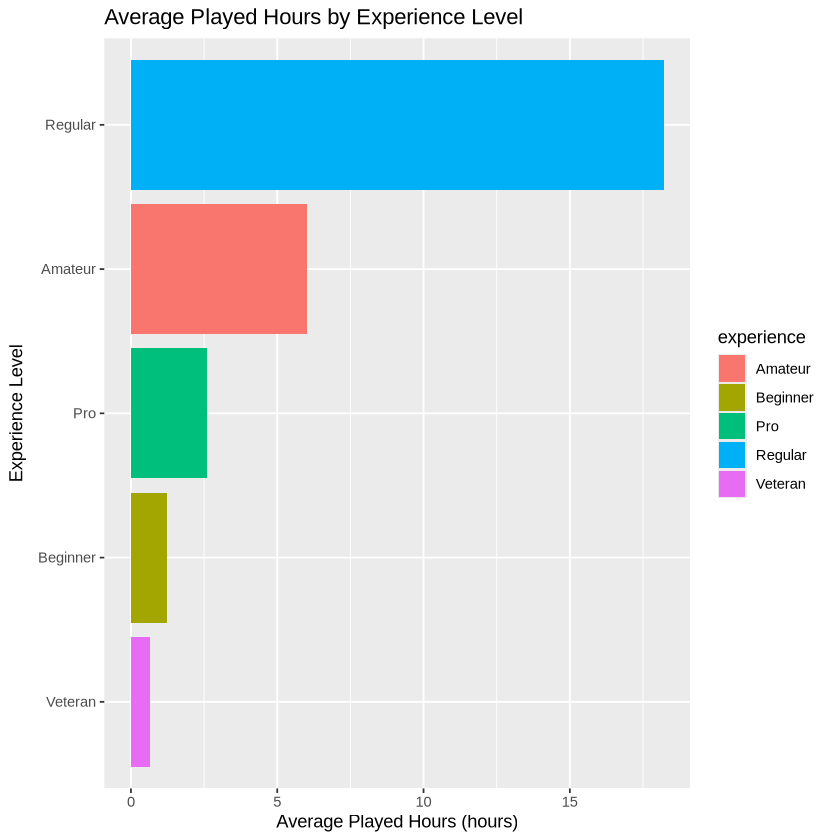

In [9]:
players |>
  group_by(experience) |>
  summarise(mean_played_hours = mean(played_hours, na.rm = TRUE)) |>
  ggplot(aes(x = reorder(experience, mean_played_hours), y = mean_played_hours, fill = experience)) +
  geom_col(show.legend = TRUE) +
  coord_flip() +
  labs(
    title = "Average Played Hours by Experience Level",
    x = "Experience Level",
    y = "Average Played Hours (hours)"
  ) 

**Age distribution of players**

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


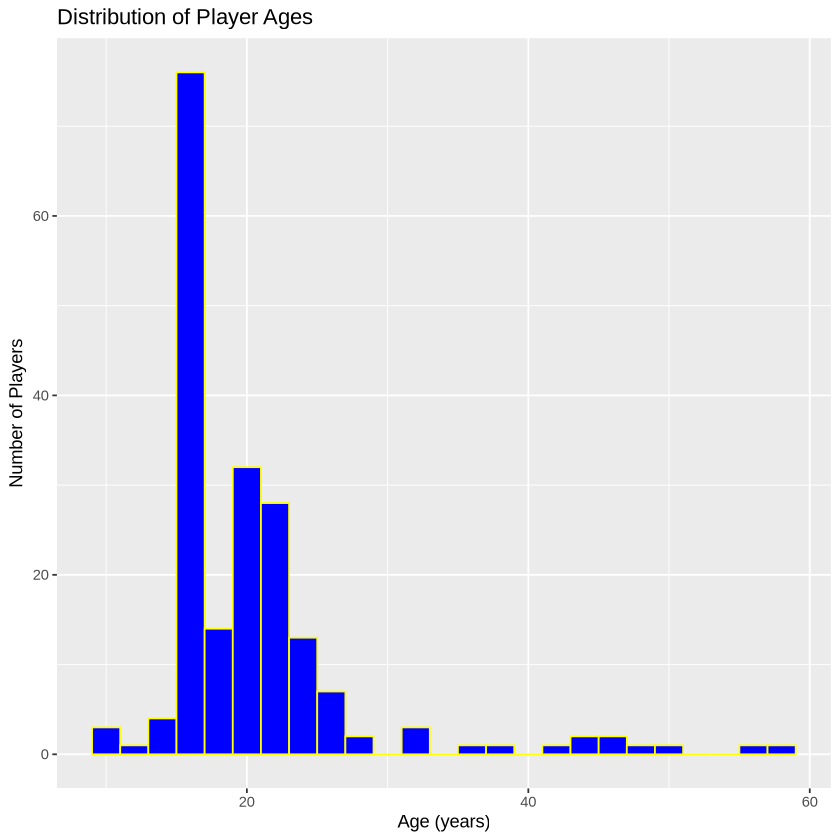

In [10]:
ggplot(players, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "blue", color = "yellow") +
  labs(
    title = "Distribution of Player Ages",
    x = "Age (years)",
    y = "Number of Players"
  ) 


**Insights from early data analysis**

- The dataset loads cleanly with no major formatting issues.  
- The average played hours differ significantly across experience levels: players who identify as "Pro" or "Veteran" tend to have the highest playtime, while "Amateur" and "Regular" players spend less time in the game.
- The age distribution shows that most players are teenagers or young adults (around 15–21 years old), with very few older participants.
- No major missing values are visible.
- These patterns suggest that experience level and played hours could be useful predictors for whether a player subscribes to the newsletter.


# 4. Methods and Plan

**Method:** K-Nearest Neighbours (KNN) Classification

Because the response variable (`subscribe`) is binary (TRUE/FALSE), I will use a K-Nearest Neighbours (KNN) classification model to predict whether a player subscribes to the newsletter based on their characteristics (e.g., experience level, played hours, age, and gender). This approach compares each player to their closest neighbours in the dataset to predict the outcome.

### Why this method is good for this project
- KNN classification is good for predicting categorical outcomes like subscribed or not subscribed.
- It makes very few assumptions about the data and can capture non-linear relationships between variables which linear regression is not very good at.

### Assumptions made about the data
- The data has been properly scaled (all numeric predictors are on comparable ranges).
- There is enough data for each class so that neighbours provide useful information.

### Potential limitations or weaknesses
- For higher values, there might be fewer closest neighbors, so they can plateau out
- If the data is more linear, then it will have a harder time to capture the correlation

### Model comparison and selection
The value of **K** will be chosen using cross-validation on the training data, testing several K values (e.g., 3, 5, 7, 9) and comparing their accuracy.  
Performance will be measured using classification metrics such as accuracy and the misclassification rate.  

### Data processing and splitting plan
1. **Data Wrangling**
   - Merge `players.csv` and `sessions.csv` by `hashedEmail` to create one player-level dataset.
   - Create features such as total played hours or number of sessions.
   - Convert categorical variables like `experience` or `gender` into numeric variables.
   - Scale the data properly if needed 

2. **Data Splitting**
   - Split the data into training (75%) and testing (25%) sets after all wrangling is complete.
   - Use the training data to tune and fit the KNN model.
   - Use the test data to evaluate its final accuracy on unseen data.

3. **Cross-Validation**
   - Apply 5-fold cross-validation within the training set to find the optimal value of K and assess model stability.

# GitHub Repository